<a href="https://colab.research.google.com/github/panghanwu/pytorch_example/blob/main/residua_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

In [ ]:
import pandas as pd
import glob
import os

# dataframe
img_dir = glob.glob('drive/MyDrive/Biodiversity/201119_job_test/SEM_pictures/*')
img_path = []
img_class = []
class_code = []

for code, dir in enumerate(img_dir):
    img_list = glob.glob(dir + '/*')
    cls = os.path.split(dir)[-1]

    for img in img_list:
        img_path.append(img)
        img_class.append(cls)
        class_code.append(code)


data = {
    'img_path': img_path,
    'img_class': img_class,
    'class_code': class_code
}

img_df = pd.DataFrame(data)

img_df

,img_path,img_class,class_code
0,drive/MyDrive/Biodiversity/201119_job_test/SEM...,Apristurus gibbosus,0
1,drive/MyDrive/Biodiversity/201119_job_test/SEM...,Apristurus gibbosus,0
2,drive/MyDrive/Biodiversity/201119_job_test/SEM...,Apristurus gibbosus,0
3,drive/MyDrive/Biodiversity/201119_job_test/SEM...,Apristurus gibbosus,0
4,drive/MyDrive/Biodiversity/201119_job_test/SEM...,Apristurus gibbosus,0
...,...,...,...
774,drive/MyDrive/Biodiversity/201119_job_test/SEM...,Squalus acanthius,42
775,drive/MyDrive/Biodiversity/201119_job_test/SEM...,Squalus acanthius,42
776,drive/MyDrive/Biodiversity/201119_job_test/SEM...,Squalus acanthius,42
777,drive/MyDrive/Biodiversity/201119_job_test/SEM...,Squalus acanthius,42


In [ ]:
from sklearn.model_selection import train_test_split

x_tra, x_val, y_tra, y_val = train_test_split(img_path, class_code, test_size=.25)
print(len(x_tra), len(x_val), len(y_tra), len(y_val))

584 195 584 195


# Data Loader

In [ ]:
from PIL import Image
from torchvision import transforms
import numpy as np
import torch

# augmentation
tra_transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=30,
        shear=10
    ),
    transforms.RandomResizedCrop(224),
    transforms.GaussianBlur(5, sigma=(.1, 1.0)),
    transforms.ColorJitter(
        brightness=.1,
        contrast=.1
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225]
    )
])

# validation resize
val_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225]
        )
])



In [ ]:
from torch.utils.data.dataset import Dataset

# dataset
class MyDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms


    def __getitem__(self, index):
        path = self.img_path_list[index]
        img = Image.open(path)
        img = img.convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        
        label = self.label_list[index]

        return (img, label)

    def __len__(self):
        return len(self.img_path_list)

train_dataset = MyDataset(
    x_tra,
    y_tra,
    tra_transform
)

valid_dataset = MyDataset(
    x_val,
    y_val,
    val_transform
)

print(len(train_dataset), len(valid_dataset))

584 195


In [ ]:
from torch.utils.data import DataLoader

# data loader
train_loader = DataLoader(
    train_dataset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=4
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=4
)

next(iter(train_loader))

[tensor([[[[-2.0323, -1.9980, -1.8782,  ..., -0.0116, -0.0458, -0.0458],
           [-1.9467, -1.9124, -1.8268,  ...,  0.0227, -0.0458, -0.0629],
           [-1.8097, -1.8097, -1.8439,  ..., -0.1143, -0.2171, -0.2513],
           ...,
           [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
           [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
           [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837]],
 
          [[-1.9482, -1.9132, -1.7906,  ...,  0.1176,  0.0826,  0.0826],
           [-1.8606, -1.8256, -1.7381,  ...,  0.1527,  0.0826,  0.0651],
           [-1.7206, -1.7206, -1.7556,  ...,  0.0126, -0.0924, -0.1275],
           ...,
           [-2.0007, -2.0007, -2.0007,  ..., -2.0007, -2.0007, -2.0007],
           [-2.0007, -2.0007, -2.0007,  ..., -2.0007, -2.0007, -2.0007],
           [-2.0007, -2.0007, -2.0007,  ..., -2.0007, -2.0007, -2.0007]],
 
          [[-1.7173, -1.6824, -1.5604,  ...,  0.3393,  0.3045,  0.3045],
           [-

## Set GPU

In [ ]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('GPU:', torch.cuda.is_available())

GPU: True


## View images

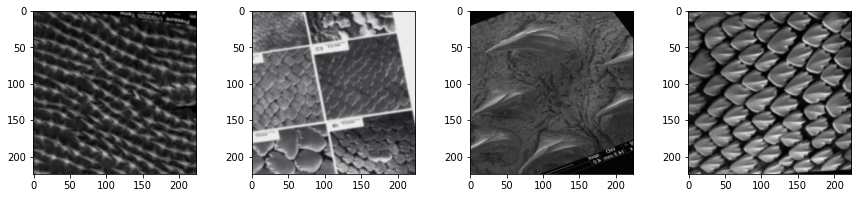

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def tenor2img(inp):
    mean = np.array([.485,.456,.406])
    std  = np.array([.229,.224,.225])

    inp = inp.numpy().transpose((1,2,0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    return inp

# get one batch
images, labels = next(iter(train_loader))

# plot
n = images.shape[0]
plt.figure(figsize=(15,3))

for i in range(n):
    plt.subplot(1, 4, i+1)

    img = tenor2img(images[i])
    plt.imshow(img)

plt.show()

## Set transferred model

In [ ]:
from torchvision import models

# ResNet
my_model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
from torch import nn, optim

num_ftrs = my_model.fc.in_features

# set output to number of classes
my_model.fc = nn.Linear(num_ftrs, 43)

my_model = my_model.to(device)

# config
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=.1)

my_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Fuction

In [ ]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model = copy.deepcopy(model.state_dict())
    best_accuracy = .0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-' * 10)

        # training
        # set model to training mode
        model.train()

        running_loss = .0
        running_corrects = 0

        for input, label in train_loader:
            # print('good')
            input = input.to(device)
            label = label.to(device)
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
                output = model(input)
                _, preds = torch.max(output, 1)
                loss = criterion(output, label)

                # backward
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * input.size(0)
            running_corrects += torch.sum(preds==label.data)
        
        scheduler.step()
        epoch_loss = running_loss / len(train_dataset)
        epoch_accuracy = running_corrects.double() / len(train_dataset)
        print('[train] Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss,epoch_accuracy), end='  ')

        # validation
        model.eval()

        running_loss = .0
        running_corrects = 0

        for input, label in valid_loader:
            input = input.to(device)
            label = label.to(device)
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(False):
                output = model(input)
                _, preds = torch.max(output, 1)
                loss = criterion(output, label)

            # statistics
            running_loss += loss.item() * input.size(0)
            running_corrects += torch.sum(preds==label.data)

        epoch_loss = running_loss / len(valid_dataset)
        epoch_accuracy = running_corrects.double() / len(valid_dataset)
        print('[valid] Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss,epoch_accuracy))

        # save model 
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            best_model = copy.deepcopy(model.state_dict())
    
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_accuracy))

    # load best model weights
    model.load_state_dict(best_model)
    
    return model


## Train model

In [ ]:
my_model = train_model(my_model, criterion, optimizer, scheduler, num_epochs=100)

Epoch 0/99
----------
[train] Loss: 2.7060 Acc: 0.3168  [valid] Loss: 1.8189 Acc: 0.5897

Epoch 1/99
----------
[train] Loss: 2.2204 Acc: 0.4332  [valid] Loss: 1.6421 Acc: 0.5538

Epoch 2/99
----------
[train] Loss: 1.9792 Acc: 0.4812  [valid] Loss: 2.0142 Acc: 0.5949

Epoch 3/99
----------
[train] Loss: 1.8827 Acc: 0.5017  [valid] Loss: 1.3776 Acc: 0.6256

Epoch 4/99
----------
[train] Loss: 1.6484 Acc: 0.5565  [valid] Loss: 1.2750 Acc: 0.6718

Epoch 5/99
----------
[train] Loss: 1.5636 Acc: 0.5445  [valid] Loss: 1.2683 Acc: 0.6974

Epoch 6/99
----------
[train] Loss: 1.5334 Acc: 0.5548  [valid] Loss: 1.2507 Acc: 0.6615

Epoch 7/99
----------
[train] Loss: 1.3067 Acc: 0.6301  [valid] Loss: 0.9529 Acc: 0.7231

Epoch 8/99
----------
[train] Loss: 1.0810 Acc: 0.6798  [valid] Loss: 0.8405 Acc: 0.7333

Epoch 9/99
----------
[train] Loss: 1.0025 Acc: 0.7140  [valid] Loss: 0.7981 Acc: 0.7487

Epoch 10/99
----------
[train] Loss: 1.0057 Acc: 0.7158  [valid] Loss: 1.0187 Acc: 0.7128

Epoch 11/